## Aplicação de técnicas de NLP e Aprendizado de máquina para realizar o reconhecimento de tópicos de forma não supervisionada

In [1]:
import pandas as pd
import numpy as np
import regex as re
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom 


#### 1. Importando dados da preparação e stopwords

In [2]:
PARQUET_INFORMACOES_PREPARADAS = '../../Data/Processed/informacoes_preparadas.parquet'

df= pd.read_parquet(PARQUET_INFORMACOES_PREPARADAS)

In [3]:
df.head()

,Titulo,Texto,Topico
0,Despachos SCG/ANEEL nº 1500 1.501 1.503 1.5...,levamos ao conhecimento os despachos scg/aneel...,Alteração das características técnicas
1,Resoluções Autorizativas ANEEL nº 6.375 nº 6....,levamos ao conhecimento as resoluções autoriza...,Outorga
2,Resoluções Autorizativas ANEEL nº 6.375 nº 6....,levamos ao conhecimento as resoluções autoriza...,Outros
3,Resolução Autorizativa ANEEL nº 6.401,levamos ao conhecimento a resolução autorizati...,Outros
4,Resolução Autorizativa ANEEL nº 6.402,levamos ao conhecimento a resolução autorizati...,Outros


In [4]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [5]:
# Pegando só os tópicos mais representativos
df = df[df['Topico'] !=  'Outros']

In [6]:
df.Topico.value_counts()

Entrada em operação                                             2511
Outorga                                                         1537
Instalação de interesse restrito                                1480
REIDI - Regime Especial de Incentivos para Desenvolvimento d    1460
Produção Independente e Autoprodutor                            1296
Alteração das características técnicas                          1249
Exploração de empreendimento                                    1065
Procedimentos e diretrizes do Setor Elétrico                    1024
Entrada em Operação Comercial                                    991
Cronograma de implantação                                        982
Entrada em Operação Teste                                        958
Name: Topico, dtype: int64

#### 2. Vetorizando por tf-idf

In [7]:
documents = df.Texto.values 

no_features = 1000

tfidf_vector = TfidfVectorizer(max_df=0.95, min_df=10,
                               max_features=no_features,
                               stop_words=stopwords
                               )

tfidf = tfidf_vector.fit_transform(documents)

tfidf_feature_names = tfidf_vector.get_feature_names_out()

In [8]:
D = tfidf.todense().tolist()

In [9]:
pd.DataFrame(D, columns=tfidf_feature_names).head()

,00,000,0001,003,01,02,03,04,05,06,...,xiii,xiv,zona,ângela,íntegra,íntegras,órgãos,ônus,última,único
0,0.0,0.052278,0.0,0.0,0.031273,0.0,0.0,0.0,0.010943,0.023637,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.032718
1,0.0,0.000000,0.0,0.0,0.202433,0.0,0.0,0.0,0.030358,0.032786,...,0.0,0.0,0.0,0.0,0.03207,0.0,0.0,0.0,0.0,0.105890
2,0.0,0.086832,0.0,0.0,0.051944,0.0,0.0,0.0,0.000000,0.353337,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.054343
3,0.0,0.000000,0.0,0.0,0.048880,0.0,0.0,0.0,0.000000,0.332496,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.051138
4,0.0,0.043499,0.0,0.0,0.026022,0.0,0.0,0.0,0.010927,0.023601,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.027224


#### 3. Normalização por Standard Scaler

In [10]:
scaler = StandardScaler()
D = scaler.fit_transform(D)

In [38]:
D.shape

(14553, 1000)

In [29]:
# ThumbRule quantidade de neurônios - Para cada neurônio 5 dados
5 * np.sqrt(D.shape[0])

603.179077886493

In [33]:
n_neurons = 25
m_neurons = 24

som = MiniSom(n_neurons, m_neurons, no_features)
som.pca_weights_init(D)

som.train(D, 30000, random_order=True, verbose=True)

 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 15.30099511594862


In [34]:
top_keywords = 10

codebook = som.get_weights()

count = 1
for idx in range(n_neurons):
    for jdx in range(m_neurons):
        keywords_list_idx = np.argsort(codebook[idx, jdx, :])[-top_keywords:]
        keywords = ' '.join([tfidf_feature_names[n] for n in keywords_list_idx])
        print(f"Topico {count}: {keywords}")
        count += 1

Topico 1: nogueira gentil biblioteca despachos deste substitui constantes júnior decisão estará
Topico 2: totalizando rio cv eólica sfg grande rn norte 100 bento
Topico 3: empresa sfg totalizando resolveu rs 33 maior sol ceará ce
Topico 4: power cv sfg 2018 xii serra ba 28 morro chapéu
Topico 5: titularidade resolveu capacidade eol liberar ug9 sfg empresa cv delta
Topico 6: código sfg decidiu usinas ute exploração consórcio 27 referidas sp
Topico 7: liberar empresa 08 mato ph sfg municípios pch verde grosso
Topico 8: sfg rs minas solar dia 000 33 mg gerais paracatu
Topico 9: conferidas sfg grande 100 ug9 publicado 2017 2014 conhecimento levamos
Topico 10: 07 sfg 08 publicado conhecimento levamos resolve 2017 delta 300
Topico 11: pch referidas operação pedro comercial vigorará propriedade referida suspensão condição
Topico 12: conferidas cv sfg publicado ba bahia conhecimento levamos parque eólico
Topico 13: ug8 ug9 ba 200 campo parque 05 januário eólico 78
Topico 14: bahia conferidas v

In [35]:
map_categories = {v: k for k, v in enumerate(df.Topico.unique())}
labels = df.Topico.unique()

target = [map_categories[l] for l in df.Topico.values]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

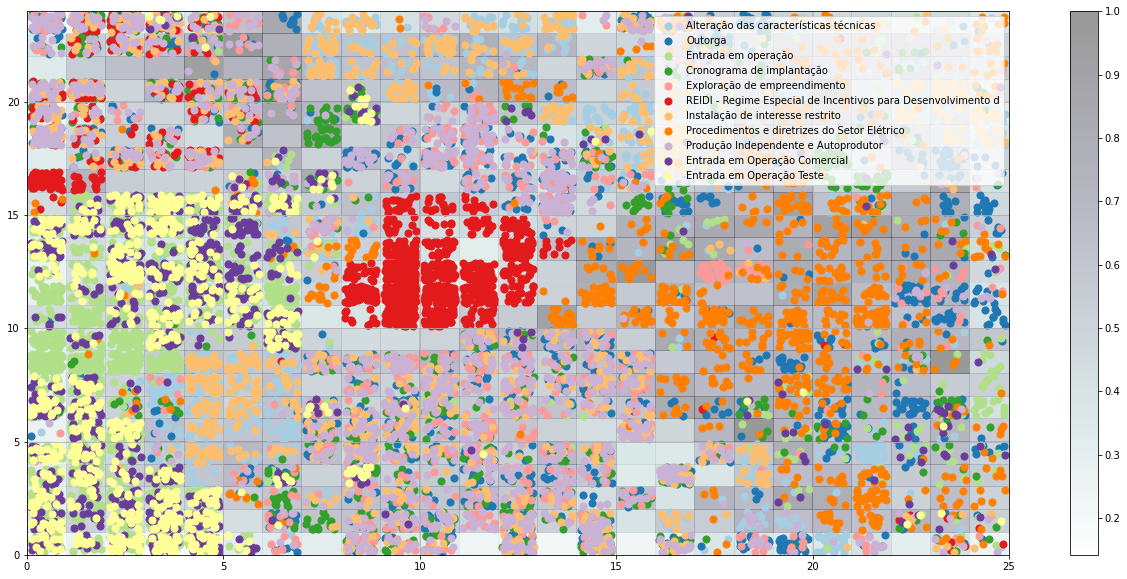

In [36]:
# Neurônios mais ativados por documento
winners = [som.winner(doc) for doc in D]

plt.figure(figsize=(22, 10))
plt.pcolor(som.distance_map().T, cmap="bone_r", alpha=.4)
plt.colorbar()

w_x, w_y = zip(*winners)
w_x = np.array(w_x)
w_y = np.array(w_y)

for t in np.unique(target):
    idx_target = target == t
    plt.scatter(w_x[idx_target] + 0.5 + ( np.random.rand(len(w_x[idx_target])) -.5) * .8,
                w_y[idx_target] + 0.5 + ( np.random.rand(len( w_y[idx_target] )) -.5) * .8,
                s=50,
                c=plt.cm.Paired(t),
                label=labels[t])
plt.legend(loc='upper right')
plt.grid()

### Outra visualização

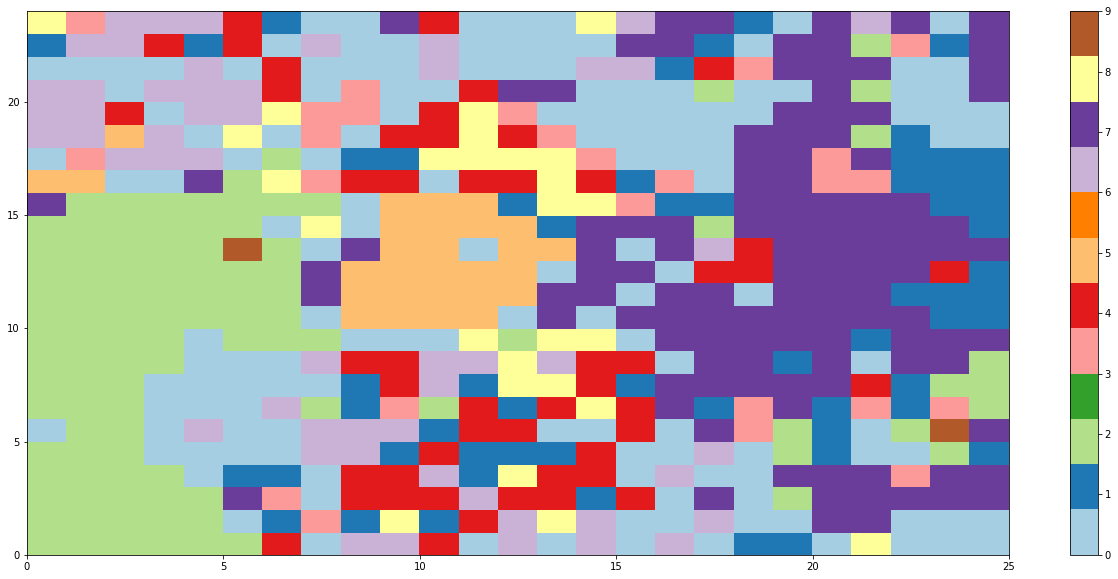

In [37]:
# Mostra as separações por classes dada a maior quantidade de tipos

map_labels = np.zeros((n_neurons, m_neurons))

for (n1, n2), counter in som.labels_map(D, target).items():
     map_labels[n1, n2] = max(counter, key= counter.get)

plt.figure(figsize=(22, 10))

plt.pcolor(map_labels.T, cmap='Paired', vmin=0, vmax=9)

plt.colorbar()

### Como o interesse é o de identificar entidades, técnicas como a de lemetização não são interessantes, pois poderiam diminuir a quantidade de informações de interesse. Podemos identificar também que muitas palavras poderiam ainda ser eliminadas como stopwords e este processo poderia se repetir por muitas vezes. A título de exercício vamos continuar o processamento com todas as palavras vetorizadas.

## 3. Modelagem de tópicos com NMF

Fatoração de matriz não negativa (NMF) é uma técnica não supervisionada, logo, não há rotulagem de tópicos nos quais o modelo será treinado. O NMF decompõe vetores de dimensões elevadas em uma representação de dimensões inferiores. Esses vetores de dimensão inferior são não negativos, o que também significa que seus coeficientes não são negativos.

Usando a matriz original (X), o NMF fornecerá duas matrizes (W e H), onde:
 * W são os tópicos encontrados 
 * H são os coeficientes (pesos) para esses tópicos. 

Em outras palavras: X são documentos por palavras (original), H são documentos por tópicos e W são tópicos por palavras.

Para o nosso caso, assumindo 14553 documentos, 1000 palavras e 10 tópicos, obteríamos as seguintes 3 matrizes:

X = tfidf_vectorizer.transform(textos dos documentos)<br>
W = nmf.components_<br>
H = nmf.transform(X)<br>
X = 14553 x 1000<br>
W = 14553 x 10<br>
H = 10 x 1000<br>

O NMF modificará os valores iniciais de W e H para que o produto se aproxime de A até que o erro de aproximação convirja ou as iterações máximas sejam alcançadas.

Em nosso caso, os vetores de alta dimensão serão pesos tf-idf, mas podem ser qualquer coisa, incluindo vetores de palavras ou uma simples contagem bruta de palavras.

### 3.1 Uso de NMF para 10 tópicos, 10 palavras por tópico

In [39]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [41]:
vocab = np.array(tfidf_feature_names)

In [42]:
# Quantidade de palavras nos tópicos
num_top_words=10

model_nmf = NMF(n_components=10, max_iter=350, init='nndsvd')

W = model_nmf.fit_transform(tfidf)

H = model_nmf.components_

print(show_topics(H))

['art nº resolução lei geradora 1996 central início energia 1º', 'conferidas serviços outubro 22 nº geração 2013 considerando aneel fiscalização', 'mme portaria nº interessada desenvolvimento reidi objeto art planejamento 1º', 'portaria projeto art 1º nº implantação autorizada nesta receita federal', 'localização interessados 00 usina modalidade unidades geradoras nº operação kw', 'alterar kv nº transmissão ii 138 outorgada passará 2017 subestação', 'interessado biblioteca íntegra gov www autos aneel br estará regimento', 'ufv rs janaúba solar futura sol fotovoltaica kw ltda 000', 'ventos eol santa januário tereza ângela 2022 cv energias renováveis', 'sfg kw despacho liberar totalizando 2018 eol capacidade 2019 empresa']


### 3.2 Visulização de tópicos com NMF e LDA [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) por Olivier Grisel <olivier.grisel@ensta.org>, Lars Buitinck e Chyi-Kwei Yau <chyikwei.yau@gmail.com>

14553 Documentos, 1000 palavras, 10 tópicos e 20 top palavras

Extracting tf-idf features for NMF...
done in 5.290s.
Extracting tf features for LDA...
done in 4.950s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=14553 and n_features=1000...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 8.843s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


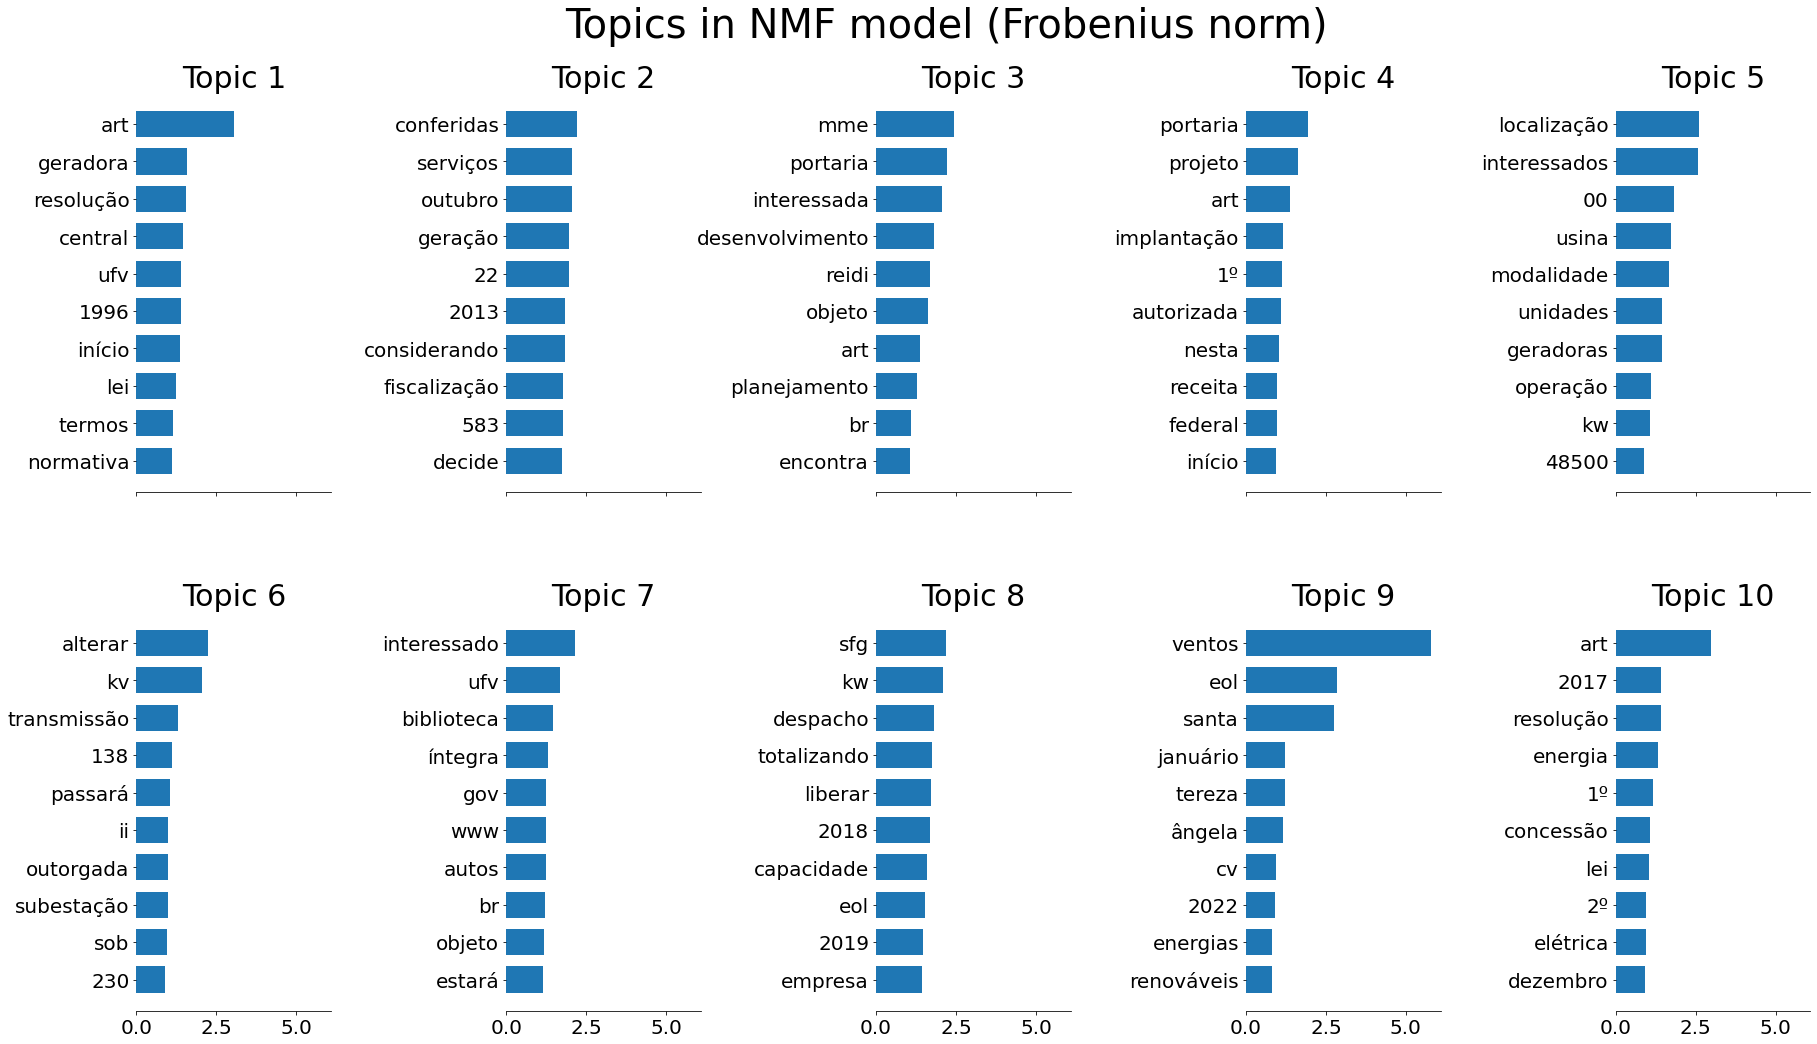



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=14553 and n_features=1000...


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


done in 140.532s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


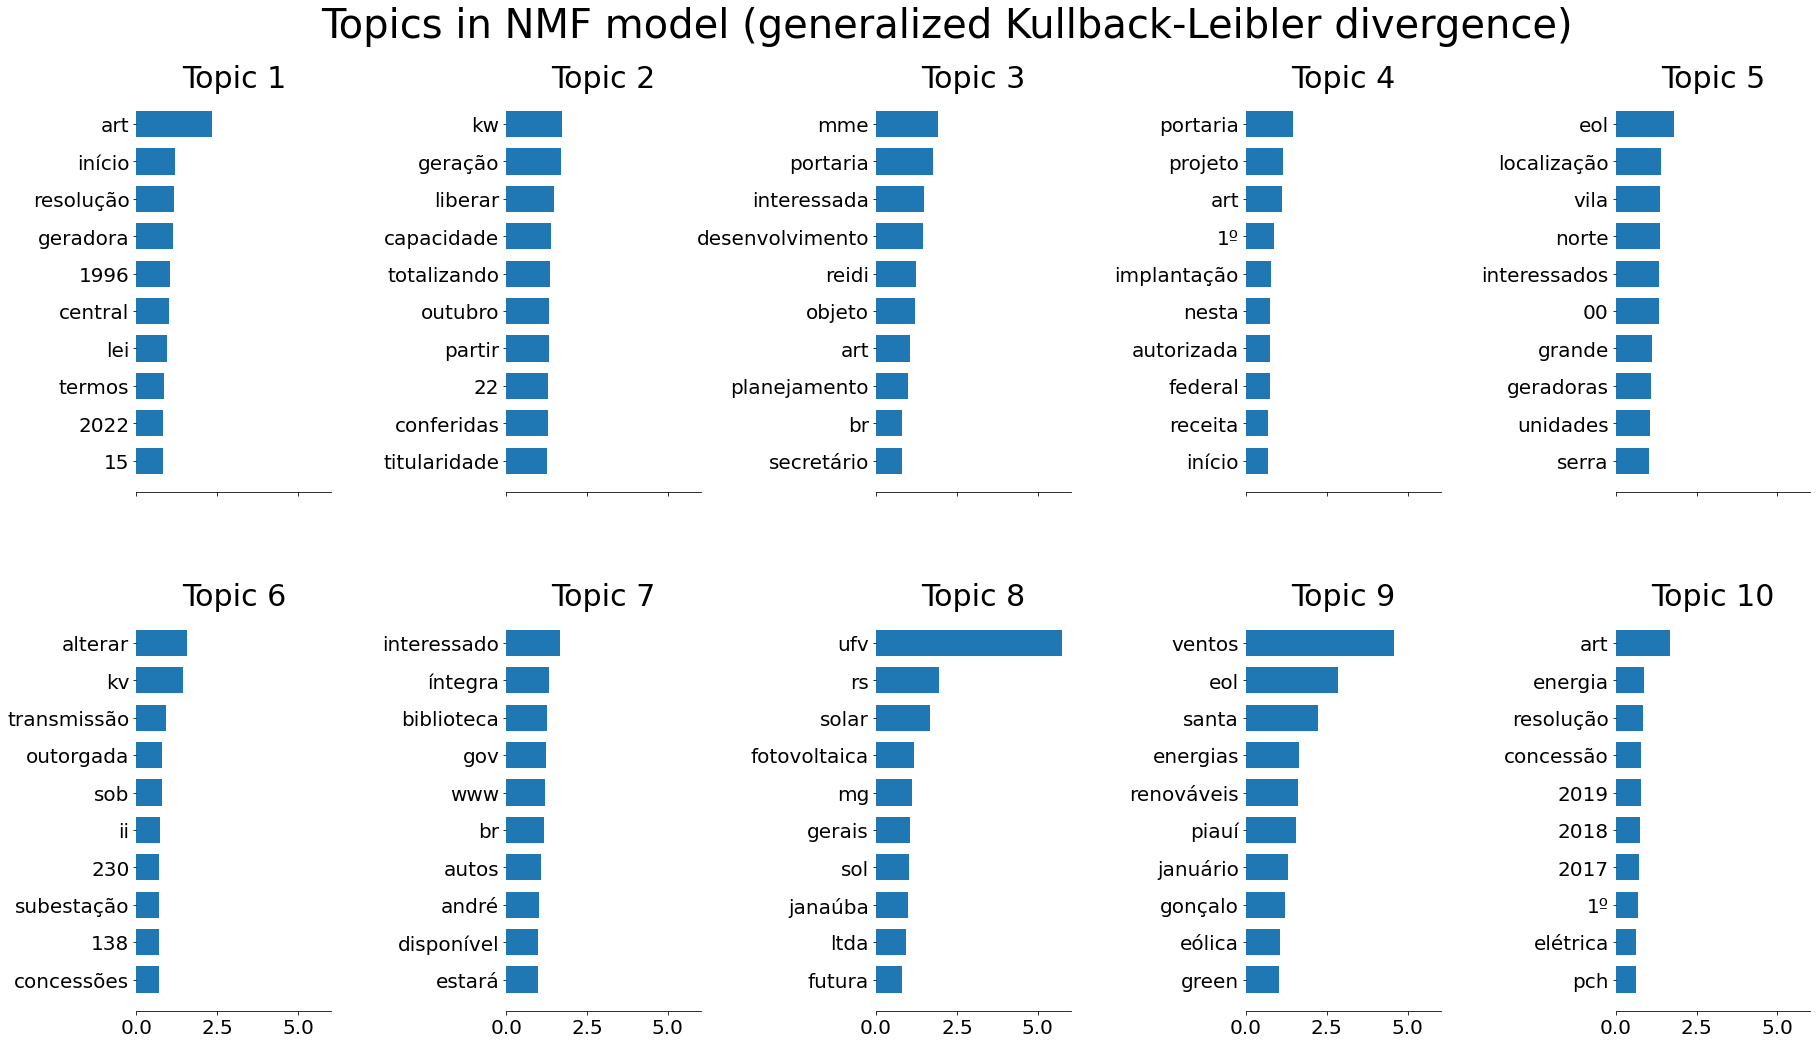



 Fitting LDA models with tf features, n_samples=14553 and n_features=1000...
done in 40.745s.


C:\Users\marce\.virtualenvs\mod6_algo_nao_supervisionados-eVDWf6jX\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


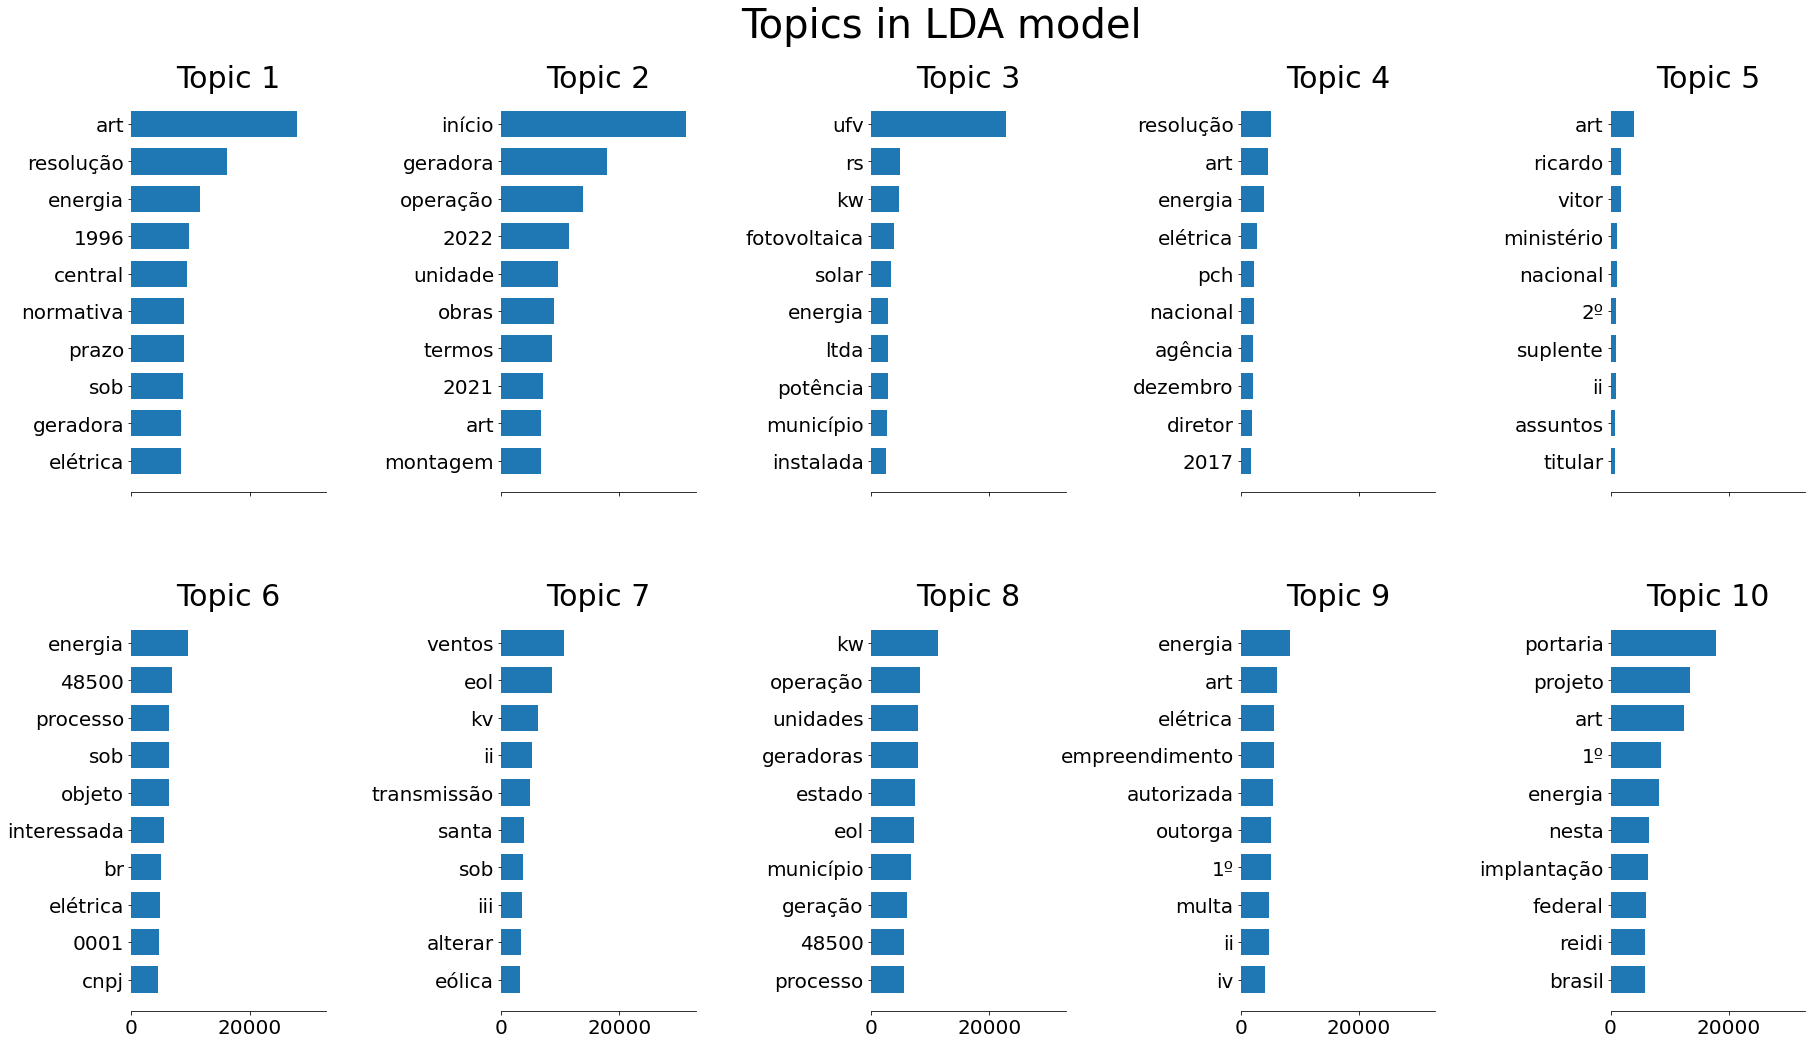

In [43]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 14553
n_features = 1000
n_components = 10
n_top_words = 10

# Adaptação do data_sample
data_samples = (df['Texto'])

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3,
                                     max_features=n_features,
                                     stop_words=stopwords)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=3,
                                # max_features=n_features,
                                stop_words=stopwords)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5, init = 'nndsvda').fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')